# Engenharia de Features e Modelagem

## Setup Inicial

Iniciamos esse segumento carregando as bibliotecas que serão utilizadas e as configurações iniciais:

In [1]:
import os
import datetime
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, RandomizedSearchCV, cross_validate
from sklearn.inspection import permutation_importance

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# Dribla warnings do sklearn:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

sns.set()  # seta gráficos nas configurações padrões do seaborn
random_state = 0  # para resultados serem reproduzíveis
number_splits = 5  # número de divisões para o Kfold

df = pd.read_csv("train.csv")

As métricas utilizadas para avaliação dos modelos será a raiz quadrática média dos erros (RMSE) entre os valores observados e as predições bem como o $R^2$. Para fins de aprendizado, e também curiosidade, avaliaremos mais de um modelo industrial de regressão do sklearn, e para tanto criamos algumas funções para modelagem, avaliação e apresentação dos resultados de forma que a inclusão e exclusão de algum modelo possua um baixo custo:

In [2]:
score_list = ['neg_mean_squared_error','r2']
limits = [10.5, 14]


def model_string_formatter(string):
    return string.split("(", 1)[0]


def rmse(neg_mean_absolute_error):
    return np.sqrt(-neg_mean_absolute_error)


def plot_comparison(results):    

    g = sns.PairGrid(results, y_vars="Model", x_vars=["RMSE", "r2"], height=(len(results) * 0.8), aspect= (4 / len(results)))
    g.map(sns.barplot, palette="Blues_r")
    sns.set()
    for graph, ax in enumerate(g.axes.flat):
        for tick in range(len(results)):
            ax.text(results.iloc[:, graph + 1].values[tick], tick, '{:.3f}'.format(results.iloc[:, graph + 1].values[tick]), color='black', verticalalignment="center")
    plt.show()

    
def evaluate(models, X, y, kfold, scoring=score_list):
    
    rmse_perf, r2_perf, model_desc, cv_results = [], [], [], []
    
    for i, model in enumerate(models):
        
        cv_results.append(cross_validate(model, X, y, cv=kfold, scoring=score_list, return_train_score=True))
        
        rmse_perf.append(rmse(np.mean(cv_results[i]['test_neg_mean_squared_error'])))
        r2_perf.append(np.mean(cv_results[i]['test_r2']))
        model_desc.append(model_string_formatter(str(model)))
        
    results = pd.DataFrame({"Model": model_desc, "RMSE": rmse_perf, "r2": r2_perf, "model": models})
    results.sort_values(by=['RMSE'], ascending=True, inplace=True)
    results = results.reset_index(drop=True)
    plot_comparison(results)
    return results


def plot_prediction(results, kfold, model):
    
    chosen_one = results[results["Model"] == model]
    train_index, test_index = next(kfold.split(X, y))
    X_test, y_test = X.iloc[test_index], y.iloc[test_index]
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    fig, ax = plt.subplots(figsize=(6,6))
    predictions = chosen_one["model"].values[0].fit(X_train, y_train).predict(X_test)
    _ = sns.regplot(y_test, y=predictions, ax=ax)
    ax.set(ylim=limits, xlim=limits, xlabel='Actual Price', ylabel='Predicted Price', title=model)
    plt.plot(limits, limits, color='r', linestyle='-', linewidth=1, alpha=.7)
    overlay = 'RMSE(mean): {:.3f}\nr2(mean): {:.3f}'.format(chosen_one['RMSE'].to_numpy()[0], chosen_one['r2'].to_numpy()[0])
    plt.annotate(s=overlay,xy=(12, 10.75) ,size='large')
    plt.show()

## Estabelecendo uma referência

Definimos a seguinte lista de modelos, inicialmente sem customização dos hyperparâmetros (ou seja, vamos testá-los inicialmente com os hyperâmetros padrões, para cada um, do sklearn):

In [3]:
models = [
    LinearRegression(),
    Ridge(random_state=random_state),
    Lasso(random_state=random_state),
    GradientBoostingRegressor(random_state=random_state),
    ]

Criamos uma versão Mickey Mouse da base de dados, com apenas os features numéricos, excluíndo todos os features com algum dado faltante, apenas para realizarmos um teste e verificarmos qual seria o desempenho se nada mais fosse feito com a base de dados:

In [4]:
X = df.drop(['Id', 'SalePrice'], axis=1)
y = np.log(df['SalePrice'])

X.dropna(axis=1, inplace=True)
X = X.select_dtypes(exclude=['object'])

E assim testamos os modelos, com validação cruzada, em suas versões padrão, por meio das funções desenvolvidas acima, e obtemos as médias dos resultados, sobre os dados de teste, de cada divisão da validação cruzada (porém, o plot da previsão x valores atuais de preços é apenas para ilustração, e se refere a divisão dos dados em treinamento/testes do primeiro fold da validação cruzada):

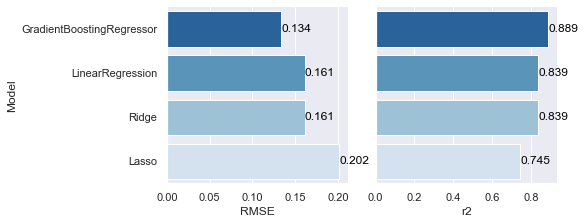

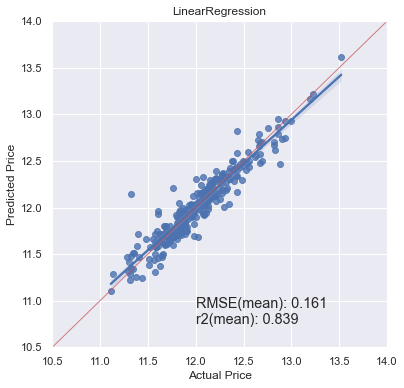

In [5]:
kfold = KFold(n_splits=number_splits, shuffle=True, random_state=random_state)

results = evaluate(models, X, y, kfold)

plot_prediction(results, kfold, model="LinearRegression")

Podemos observar que o Gradient Boosting Regressor apresenta um ótimo resultado sobre a versão Mickey Mouse de nossa base, não à toa parece ser o modelo industrial querido das competições de ML. O modelo de regressão linear está um pouco aquém, e o interessante é que é o Lasso apresenta um performance sofrível, o que podemos supor inicialmente que seja devido ao não tuning dos hyperparâmetros, o que vamos avaliar mais em frente (não vamos desistir dele).

Com relação ao campeão atual, fazemos um exercício de *permutation importance*, ou seja, qual seria a queda na métrica ($R^2$) pela permutação aleatória de determinado feature (quebrando-se assim a correlação real entre ele o target) (https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html):

In [6]:
def importance_eval(model, X, y, kfold):

    train_index, test_index = next(kfold.split(X, y))
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_test, y_test = X.iloc[test_index], y.iloc[test_index]
    n_repeats = 30

    importances = permutation_importance(model.fit(X_train, y_train), X_test, y_test, n_repeats=n_repeats, random_state=random_state)
    for i in importances.importances_mean.argsort()[::-1]:
        if (importances.importances_mean[i] - 2 * importances.importances_std[i] > 0) & (importances.importances_mean[i] > 0.005):
            print("{}: {:.3f} +/- {:.3f}".format(X_train.columns.values[i], importances.importances_mean[i], importances.importances_std[i]))

model = GradientBoostingRegressor(random_state=random_state)
importance_eval(model, X, y, kfold)

OverallQual: 0.215 +/- 0.013
GrLivArea: 0.152 +/- 0.014
YearBuilt: 0.029 +/- 0.007
BsmtFinSF1: 0.025 +/- 0.004
TotalBsmtSF: 0.023 +/- 0.005
YearRemodAdd: 0.019 +/- 0.003
OverallCond: 0.012 +/- 0.004
GarageCars: 0.012 +/- 0.003
LotArea: 0.009 +/- 0.004
GarageArea: 0.006 +/- 0.003


Podemos notar que, como suspeitamos na análise exploratória dos dados (a qual vamos nos referir a partir de agora por AED), qualidade geral da casa e área útil sobre o nível do solo desempenham papel relevante para determinação do preço da casa. Interessante que informações sobre a garagem (número carros / área) também apresenta relevância importância para a decisão do GB).

## Tratando dados faltantes

Verificamos inicialmente qual o tamanho de nosso problema de missing values por:

In [7]:
def missing_values_check(df):
    missing_val_total = df[df.columns[df.isna().any()].tolist()].isna().sum().sort_values(ascending=False)
    missing_val_perc = missing_val_total/len(df)
    print(pd.concat([missing_val_total, missing_val_perc], axis=1, keys=['Qtde', '%']))

missing_values_check(df)

              Qtde         %
PoolQC        1453  0.995205
MiscFeature   1406  0.963014
Alley         1369  0.937671
Fence         1179  0.807534
FireplaceQu    690  0.472603
LotFrontage    259  0.177397
GarageYrBlt     81  0.055479
GarageType      81  0.055479
GarageFinish    81  0.055479
GarageQual      81  0.055479
GarageCond      81  0.055479
BsmtFinType2    38  0.026027
BsmtExposure    38  0.026027
BsmtFinType1    37  0.025342
BsmtCond        37  0.025342
BsmtQual        37  0.025342
MasVnrArea       8  0.005479
MasVnrType       8  0.005479
Electrical       1  0.000685


Assim, começando do mais preocupante para o menos, podemos imaginar que os dados faltantes de PoolQC devem representar inexistência de piscina, já que vimos na AED que o pessoal em Ames não parece gostar muito de piscinas. Vamor checar isso verificando qual a qualidade das piscinas que tem área maior que zero:

In [8]:
print(df[df['PoolArea'] > 0]['PoolQC'].count())

7


Ou seja, as 1453 observações sem dados de qualidade representam casas com área zero de piscina. Assim, criaremos a categoria 'NA' para estas. Faremos o mesmo para MiscFeature que, como podemos verificar pelas categorias em sua distribuição na AED, corresponde a itens especiais diversos (como quadra de tênis), logo é de se esperar que a maioria das casas não os possua. Também o faremos para Fence (provavelmente são casas sem cercas), indicando que tais dados faltantes são na realidade 'NA'.

Já para Alley, provavelmente a falta de valores se deve a casas que não possuem acessos diferenciados (o acesso deve ser pela rua principal, que passa em frente a casa, por exemplo). Assim, também poderemos preencher com valor NA os dados faltantes.

Para FireplaceQu (qualidade das lareiras), provavelmente a falta de dados significa que o número de lareiras é zero. Checamos por:

In [9]:
print(len(df[df['FireplaceQu'].isna()]['Fireplaces'] == 0))

690


Que é exatamente o número de dados faltantes. Então para esses dados faltantes também imputaremos NA.

Para LotFrontage não sabemos se o problema é em função da falta de dados ou inexistência da possibilidade de termos uma medida de frente da propriedade devido a suas características. Como o número de dados faltantes é alto, vamos ignorar esse feature, excluíndo-o.

Para GarageYrBlt, GarageType, GarageFinish, GarageQual, GarageCond, notamos que os dados faltantes são em mesma quantidade para todos, o que indica que o problema se deve à falta de garagem nestas casas. Checamos isso cruzando com o área da garagem (igual a zero):

In [10]:
print(len(df[df['GarageType'].isna()]['GarageArea'] == 0))

81


O que confirma nossa hipótese. Logo, também utilizaremos NA para as observações categóricas. Com relação a GarageYrBlt, vamos excluí-la, visto que as outras features de datas parecem possuir melhor poder preditivo.

Assim, imputando NA para todas as features conforme prometido até então, bem como excluíndo as features GarageYrBlt e LotFrontage:

In [11]:
feature_list = ['PoolQC', 'MiscFeature', 'Fence', 'Alley', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
for feature in feature_list:
    df[feature] = df[feature].fillna('NA')

df.drop(columns=['GarageYrBlt', 'LotFrontage'], inplace=True)

Os dados faltantes de BsmtFinType2, BsmtExposure, BsmtFinType1, BsmtCond e BsmtQual parecem indicar a inexistência de porão, mas as duas últimas apresentam uma observação a mais sem dados. Assim, para avaliar nossa hipótese, verificando a área de porão disponível:

In [12]:
len(df[df['BsmtFinType1'].isna()]['TotalBsmtSF'] == 0)

37

O que parece confirmar a nossa hipótese de inexistência de porão para as observações em questão. Assim, imputamos NA para essas observações:

In [13]:
feature_list = ['BsmtFinType1', 'BsmtCond', 'BsmtQual']
for feature in feature_list:
    df[feature] = df[feature].fillna('NA')

Como restará um valor valtante para BsmtFinType2 e BsmtExposure, a preenchemos com 'Unf' e 'No', que representam as categorias predominantes nessas features:

In [14]:
df['BsmtFinType2'] = df['BsmtFinType2'].fillna('Unf')
df['BsmtExposure'] = df['BsmtExposure'].fillna('No')

Com relação as 8 observações sem dados de MasVnrArea e MasVnrType: o tipo mais comum para MasVnrType é None, conforme observamos em sua distribuição. Logo, podemos utilizar essa categoria para as 8 observações e lançar como área o valor 0, que é o que ocorre com a maioria das observações.

E temos apenas uma observação com dados faltantes para Electrical, em que preenchemos com a categoria predominante ('SBrkr').

Assim, realizando essas imputações:

In [15]:
df['MasVnrType'] = df['MasVnrType'].fillna('None')
df['MasVnrArea'] = df['MasVnrArea'].fillna(0)
df['Electrical'] = df['Electrical'].fillna('SBrkr')

E por fim verificamos se fomos bem sucedidos (no sentido de não haver mais dados faltantes):

In [16]:
missing_values_check(df)

Empty DataFrame
Columns: [Qtde, %]
Index: []


## Criação de Novas Features

Nessa etapa exploramos a criação de algumas novas features, baseadas nas existentes. Por exemplo, possuímos a área útil total acima do solo, a área útil de porão e área da garagem. Podemos criar então uma feature com a área total da casa, a soma dessas três, e podemos verificar que essa nova feature tem uma correlação maior com o preço de venda que as três anteriores:

In [17]:
df['HouseArea'] = df['GrLivArea'] + df['TotalBsmtSF'] + df['GarageArea']
print(df['HouseArea'].corr(df['SalePrice']))

0.8075184760515016


O mesmo faremos para área de varandas: possuímos quatro variáveis de área (OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch) com pouco ou nenhum poder preditivo, nem correlações significantes com outras variáveis. Então somamos as features em uma nova:

In [18]:
df['PorchArea'] = df['OpenPorchSF'] + df['EnclosedPorch'] + df['3SsnPorch'] + df['ScreenPorch']

Com relação ao número de banheiros, FullBath tem interessante correlação com o preço de venda, como pode ser visto no mapa de calor da AED (0.56). Mas há outras três features relativas a banheiros e lavabos, mas com correlações piores (HalfBath, BsmtFullBath, BsmtHalfBath). Então uma ideia pode ser gerarmos uma nova feature de banheiros, somando todos eles e considerando lavabos como "meio" banheiros. Note que assim criamos uma variável com correlação com o preço de venda maior que todas as medidas individuais:

In [19]:
df['TotalBath'] = df['FullBath'] + 0.5 * df['HalfBath'] + df['BsmtFullBath'] + 0.5 * df['BsmtHalfBath']
print(df['TotalBath'].corr(df['SalePrice']))

0.6317310679319873


Com relação às variáveis de datas, anuais, sabemos que YearRemodAdd (ano da última reforma) tem valor mínimo em 1950, se a casa foi construída antes disso, provavelmente por algum problema com a base de dados. Além disso, sabemos que o ano de venda não parece importar, mas provavelmente importa mais a idade da casa no momento da venda do que a idade da casa em relação a hoje ou a última data disponível na base de dados. Então vamos:
- Substituir o ano de reforma pelo ano de construção, se a casa foi construída antes de 1950;
- Criar uma nova feature binária indicando se a casa foi reformada ou não (pela diferença entre ano da última reforma e ano da construção);
- Criar um feature com o tempo decorrido desde a construção até o momento da venda;

In [20]:
df.loc[df['YearBuilt'] < 1950, 'YearRemodAdd'] = df[df['YearBuilt'] < 1950]['YearBuilt']
df['IsRemod'] = np.where(df['YearBuilt'] == df['YearRemodAdd'], 0, 1)
df['AgeSold'] =  df['YrSold'] - df['YearBuilt']

## Conversão de features númericas para categóricas nominais

Lembramos que MSSubClass, apesar de numérica, é categórica nominal na realidade. Assim a convertemos para nominal. Para algumas a feature do mês de venda não há ordinalidade, no sentido de que dezembro não é melhor que novembro, por exemplo. Assim também a converteremos para categórica nominal. Faremos o mesmo para o ano de venda:

In [21]:
features_list = ['MSSubClass', 'MoSold', 'YrSold']

for feature in features_list:
    df[feature] = df[feature].astype('category', copy=False)

## Agrupamento de categorias em features categóricas nominais

Como vimos na análise exploratória dos dados, o bairro é um dos features categóricos com maior capacidade de diferenciar o preço da casa. Porém, pelo alto número de categorias, e pela distribuição das casas nos bairros, podemos verificar que alguns bairros são pouco representados. Se filtrarmos, por exemplo, os bairros que possuem menos de 2% da observações:

In [22]:
s = df['Neighborhood'].value_counts() < (df.shape[0] * 0.02)
print(s[s].index.tolist())

['ClearCr', 'StoneBr', 'SWISU', 'Blmngtn', 'MeadowV', 'BrDale', 'Veenker', 'NPkVill', 'Blueste']


Vamos "unir" esses bairros nos bairros com distribuição "vizinha" (vamos selecionar aquele com mediana mais próxima). Plotando em ordem da maior para a menor mediana, podemos então propor o seguinte agrupamento: unir ClearCr com Crawfor, SWISU, NPkVill e Blueste com NAmes, StoneBr com NoRidge, Blmngtn com CollgCr, MeadowV e BrDale com IDOTRR, Veenker com Somerst:

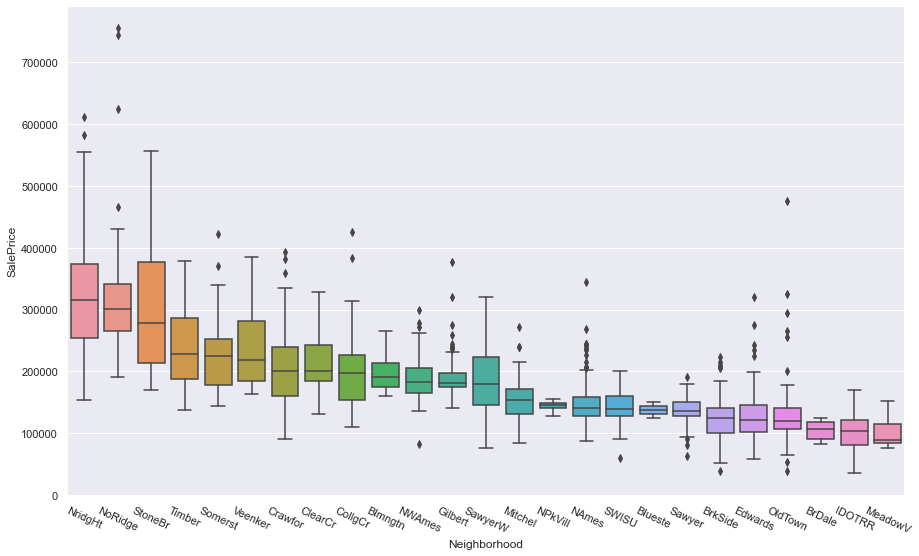

In [23]:
order = df[['Neighborhood', 'SalePrice']].groupby(by=['Neighborhood']).median().sort_values(by=['SalePrice'], ascending=False).index.tolist()
fig, ax = plt.subplots(figsize=(15, 9))
g = sns.boxplot(x=df['Neighborhood'], y=df['SalePrice'], order=order)
_ = g.set_xticklabels(g.get_xticklabels(), rotation=-25)

Procedemos então para o agrupamento com:

In [24]:
neighborhood_map = [
    ['ClearCr', 'SWISU', 'NPkVill', 'Blueste', 'StoneBr', 'Blmngtn', 'MeadowV', 'BrDale', 'Veenker'],
    ['Crawfor', 'NAmes', 'NAmes',   'NAmes',   'NoRidge', 'CollgCr', 'IDOTRR',  'IDOTRR', 'Somerst']]

for from_, to_ in zip(neighborhood_map[0], neighborhood_map[1]):
    df.loc[df['Neighborhood']==from_, 'Neighborhood'] = to_

Obtendo assim o seguinte boxplot para os bairros apoós o agrupamento:

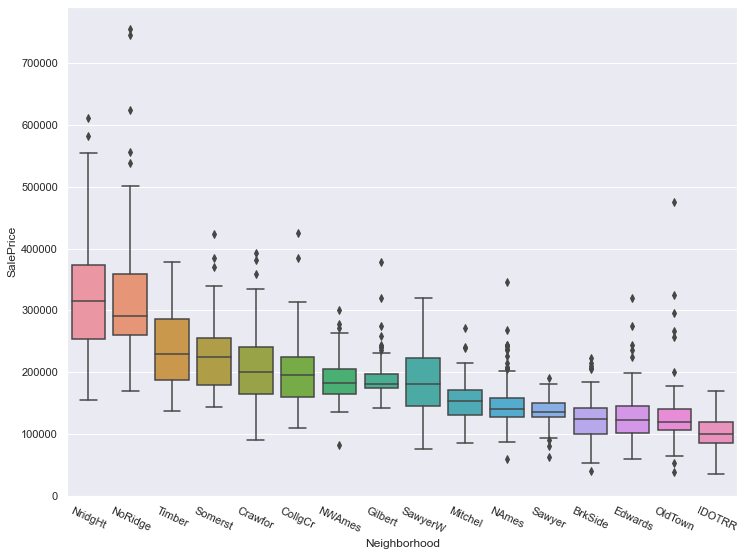

In [25]:
order = df[['Neighborhood', 'SalePrice']].groupby(by=['Neighborhood']).median().sort_values(by=['SalePrice'], ascending=False).index.tolist()
fig, ax = plt.subplots(figsize=(12, 9))
g = sns.boxplot(x=df['Neighborhood'], y=df['SalePrice'], order=order)
_ = g.set_xticklabels(g.get_xticklabels(), rotation=-25)

Raciocínio similar pode ser aplicado para outras features categóricas, em que algumas categorias, de determinada feature, possuem pouca representavidade, e dado algum possível poder preditivo das demais categorias dessa feature, poderia ser interessante proceder com agrupamento. Propomos assim então os seguintes agrupamentos:

- Foundation: manter as 3 categorias com o maior número de observações (PConc, CBlock e BrkTil) e agrupar as demais;
- MiscFeature: manter apenas Shed e agrupar as demais;
- Electrical: manter SBrkr e FuseA e agrupar as demais;
- Condition1: agrupar PosN, RRNn, PosA, RRNe em 'other' e incluir RRAe com Feedr;
- HouseStyle: manter 2Story, 1Story, 1.5Fin, Foyer e Slvl e agrupar as demais;
- GarageType: manter Attchd, Detchd e BuiltiIn e agrupar as demais;
- SaleType: manter WD, New e COD e agrupar as demais;
- MSZoning: agrupar RM e RH;
- Fence: agrupar todas as categorias, com exceção da que representa o valor Good Privacy ("GdPrv");
- LandSlope: agrupar Mod com Sev;
- ExterCond: agrupar Ex com Gd e Po com Fa;
- BsmtCond: agrupar Po com Fa;
- HeatingQC: agrupar Po com Fa;
- GarageQual: agrupar Ex com Gd e Po com Fa;
- GarageCond: agrupar Ex com Gd e Po com Fa;

In [26]:
feature_list = ['Foundation', 'MiscFeature', 'Electrical', 'Condition1', 'HouseStyle', 'GarageType', 'SaleType', 'MSZoning', 'Fence', 'LandSlope', 'ExterCond', 'BsmtCond', 'HeatingQC', 'GarageQual', 'GarageCond']

map_ = [
    [['Slab', 'Stone', 'Wood'],
     ['Gar2', 'TenC', 'Othr'],
     ['FuseF', 'FuseP', 'Mix'],
     ['PosN', 'RRNn', 'PosA', 'RRNe'] + ['RRAe'],
     ['1.5Unf', '2.5Unf', '2.5Fin'],
     ['Basment', 'CarPort', '2Types'],
     ['ConLD', 'ConLw', 'ConLI', 'CWD', 'Oth', 'Con'],
     ['RH', 'RM'],
     ['MnPrv', 'GdWo', 'MnWw'],
     ['Sev'],
     ['Ex', 'Po'],
     ['Po'],
     ['Po'],
     ['Ex', 'Po'],
     ['Ex', 'Po']
    ], 
    [['other'] * 3,
     ['NA'] * 3,
     ['other'] * 3,
     ['other'] * 4 + ['Feedr'],
     ['other'] * 3,
     ['other'] * 3,
     ['other'] * 6,
     ['other'] * 2,
     ['other'] * 3,
     ['Mod'],
     ['Gd', 'Fa'],
     ['Fa'],
     ['Fa'],
     ['Gd', 'Fa'],
     ['Gd', 'Fa']
    ]
]

for i, feature in enumerate(feature_list):
    for from_, to_ in zip(map_[0][i], map_[1][i]):
        # print(feature, ":", from_, "->", to_)
        df.loc[df[feature]==from_, feature] = to_

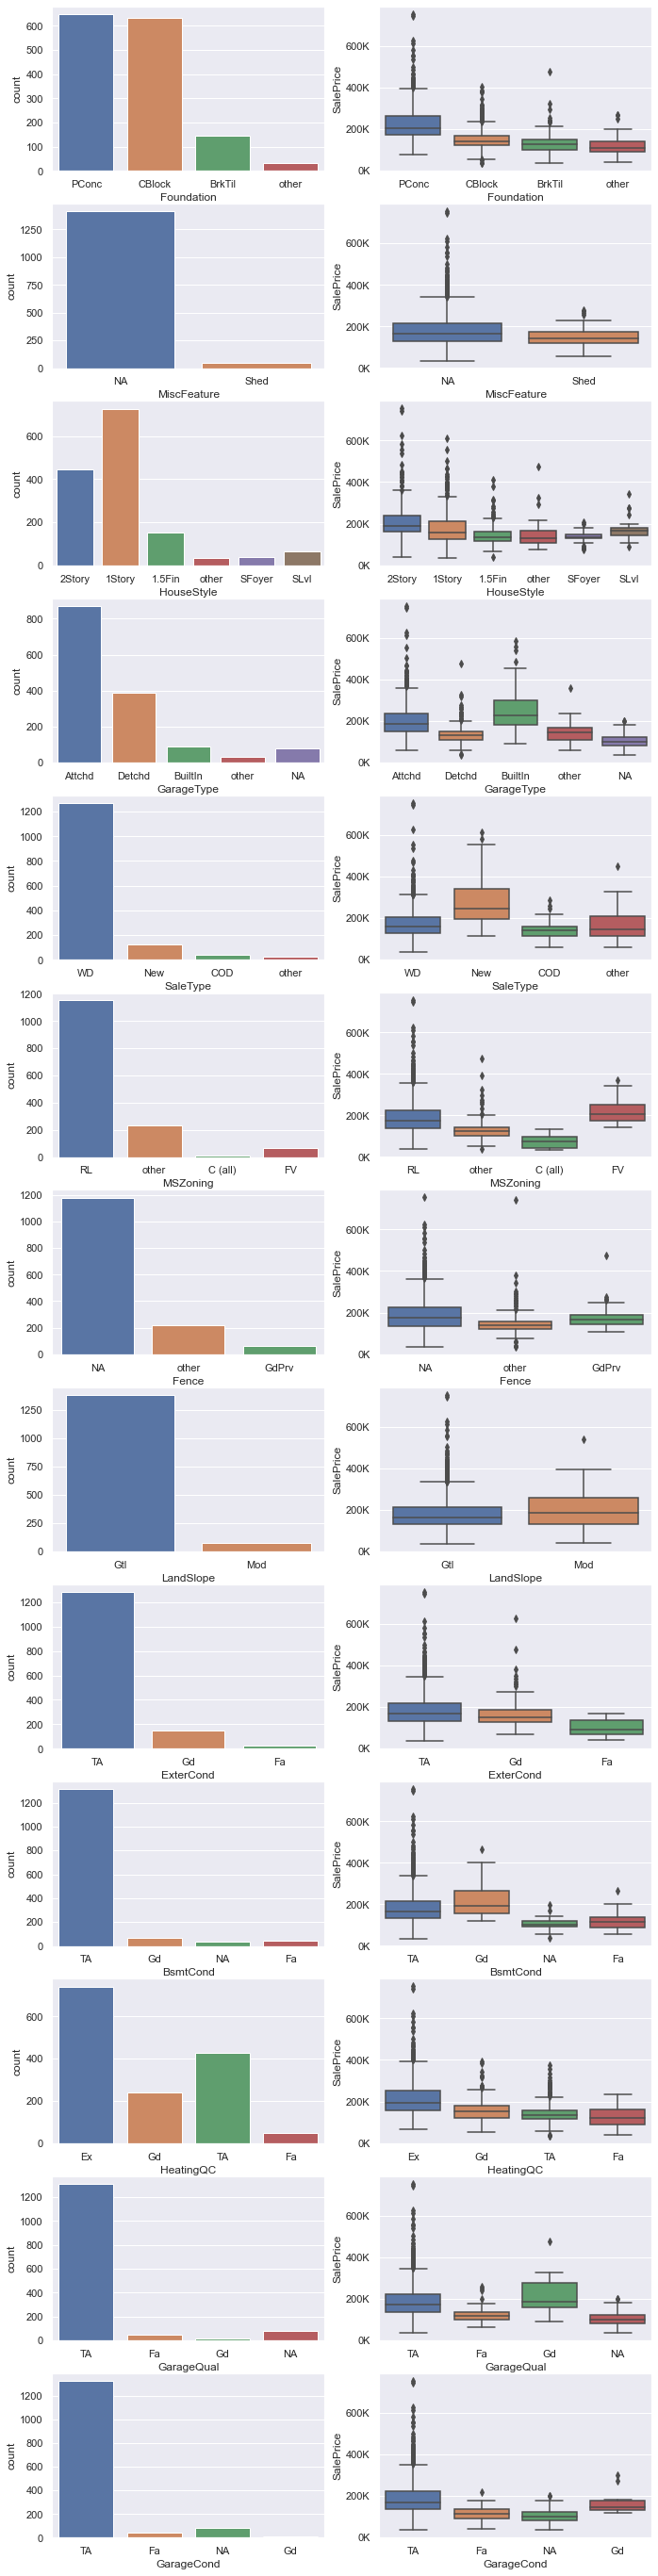

In [27]:
def plot_categorical(feature_list, single_plot_w=1.5 * 3.8, single_plot_h=3.8):
    m, n = len(feature_list), 2
    fig, ax = plt.subplots(m, n, figsize=(n * single_plot_w, m * single_plot_h))
    for i, feature in enumerate(feature_list):
        g = sns.countplot(df[feature], ax=ax[i][0])
        g = sns.boxplot(x=df[feature], y=df['SalePrice'], ax=ax[i][1])       
        g.set_yticklabels(['{:,.0f}'.format(y) + 'K' for y in g.get_yticks()/1000])

plot_categorical(feature_list[:2] + feature_list[4:])

## Conversão de features categóricos ordinais para numéricos

Algumas features categóricas são ordenadas, mas seus valores estão no formado de strings. Assim, para aquelas em que temos todos os valores (não há valores como NA, por exemplo), vamos convertê-las para o formato de inteiros que representem a ordenadação, conforme pudemos concluir pelos boxplots da análise exploratória:

In [28]:
def encodeOrdinal(feature_list, categories_list):
    for feature, categories in zip(feature_list, categories_list):
        encoder = OrdinalEncoder(categories=[categories])
        encoder.fit(df[feature])
        df[feature] = encoder.fit_transform(df[feature])

feature_list = [['LandSlope'], 
                ['ExterQual'], 
                ['ExterCond'], 
                ['HeatingQC'], 
                ['KitchenQual'], 
                ['PavedDrive']]

slope_cat = ['Gtl', 'Mod']
qual_1_cat = ["NA", "Fa", "TA", "Gd", "Ex"]
qual_2_cat = ["NA", "Po", "Fa", "TA", "Gd", "Ex"]
qual_3_cat = ["NA", "Fa", "TA", "Gd"]
drive_cat = ["N", "P", "Y"]

categories_list = [slope_cat, 
                   qual_1_cat, 
                   qual_3_cat, 
                   qual_1_cat, 
                   qual_2_cat, 
                   drive_cat]

encodeOrdinal(feature_list, categories_list)

## Seleção de Features

Na análise exploratória dos dados verificamos que algumas features possuem um categoria / valor que corresponde a quase totalidade das amostras, não possuindo assim muito poder para diferenciação de preço e tendo alto risco de gerar apenas ruído. Decidimos assim por eliminá-las:

In [29]:
drop_list = ['PoolArea', 'PoolQC', 'Utilities', 'Condition2', 'RoofMatl', 'Heating', 'Street']
df.drop(drop_list, axis=1, inplace=True)

Com criamos algumas features novas, as features utilizadas em sua criação acabam por ser redundantes. Por esse motivo, eliminamos as seguintes features:

In [30]:
drop_list = [
    'TotalBsmtSF', 'GarageArea', 
    'FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath',
    'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch',
    'YearBuilt', 'YearRemodAdd'
    ]
df.drop(drop_list, axis=1, inplace=True)

Ainda possuímos algumas variáveis de área causando multicolinearidade perfeita (como verificamos na AED), e assim eliminamos as menos informativas:

In [31]:
drop_list = [
    'BsmtFinSF2', 'LowQualFinSF'
    ]
df.drop(drop_list, axis=1, inplace=True)

E por fim eliminamos aquelas features que não apresentaram correlação, associação ou algum padrão razoável observado nos gráficos da AED relacionado com o preço de venda da casa:

In [32]:
drop_list = [
    'MiscFeature',
    'ExterCond',
    'KitchenAbvGr',
    'MiscVal'
    ]
df.drop(drop_list, axis=1, inplace=True)

## Outliers

Um de nossos principais preditores de preço é a área útil da casa. Como observamos no AED, possuímos algumas observações com área acima do solo superior a 4000 pés quadrados que destoam do padrão observado nas demais casas. Assim, optamos por eliminar as 4 observações:

In [33]:
df = df[df['GrLivArea'] < 4000]

## Preparação dos Dados para Modelagem

Para as variáveis categóricas, aplicaremos one-hot-enconding. Após isso, eliminaremos, se existentes, aquelas dummies que possuírem menos que 10 observações.

Para cada feature numérica, verificaremos a medida de assimetria (skewness) e, se maior que 1, indicando considerável assimetria a direita, aplicaremos transformação logaritmíca visando reduzi-la. Alguns algoritmos não são sensíveis a tal transformação, mas como estamos utilizando mais de um e podemos incluir facilmente outros nessa implementação, optamos por essa abordagem:

In [34]:
df = pd.get_dummies(df)

X = df.drop(columns = ['Id', 'SalePrice'])
y = np.log(df['SalePrice'])

numercial_features = X.select_dtypes(exclude=['uint8']).columns.tolist()

X_num = X[numercial_features].copy()
X_cat = X.drop(numercial_features, axis=1)

# Tratamento assimetria:
for feature in numercial_features:
    if X_num[feature].skew() > 1:
        # print("before:", df[feature].skew())
        X_num[feature] = np.log(X_num[feature] + 1)
        # print("after:", df[feature].skew())

# Esparsidade:
s = X_cat.sum() < 10
X_cat.drop(columns=s[s].index.tolist(), inplace=True)

# Composição Final:
X = pd.concat([X_num, X_cat], axis=1)

## Reavaliação e Seleção de modelos

Após nossa "engenharia de features", testamos novamente os modelos em suas configurações padrão, em validação cruzada, e é interessante notar como conseguimos melhorar o resultado do modelo de regressão linear:

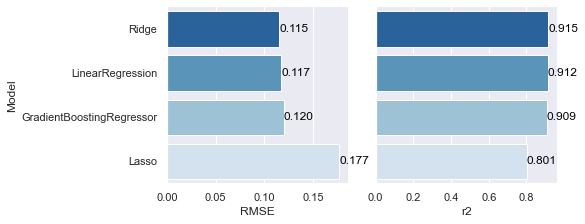

In [35]:
results = evaluate(models, X, y, kfold)

Porém, todos os modelos além do de regressão linear podem ser aperfeiçoados pela seleção de seus hyperparâmetros. Vamos avaliar o quanto podemos aperfeiçoá-los. Para isso, utilizaremos o GridSearchCV e RandomizedSearchCV do sklearn, que buscam, exaustivamente ou aleatóriamente, respectivamente, os hyperparâmetros que maximizam alguma métrica (neg_mean_squared_error em nosso caso), com base em uma lista de possíveis hyperparâmetros que gostaríamos de avaliar para cada um:

In [ ]:
lasso_parameters = {'alpha': np.linspace(0.1, 1.0, num=(10 ** 2)) ** 6}
ridge_parameters = {'alpha': np.linspace(1, 100, num=100)}
gbr_parameters = {
    "loss": ['ls', 'lad', 'huber', 'quantile'],
    "learning_rate": [0.01, 0.02, 0.025, 0.033, 0.05, 0.075, 0.1, 0.125, 0.15, 0.2],
    "min_samples_split": [0.05, 0.075, 0.1, 0.12, 0.15, 0.2, 0.25, 0.5, 1, 2, 5],
    "min_samples_leaf": [0.1, 0.25, 0.5, 1, 2, 5, 10],
    "max_depth": [3, 5, 8],
    "max_features": ["auto", "log2","sqrt"],
    "criterion": ["friedman_mse", "mse"],
    "subsample": [0.3, 0.4, 0.5, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators": [250, 500, 1000]
    }

gs_lasso = GridSearchCV(Lasso(), lasso_parameters, cv=kfold, scoring='neg_mean_squared_error')
gs_lasso.fit(X, y)
print(gs_lasso.best_estimator_)

gs_ridge = GridSearchCV(Ridge(), ridge_parameters, cv=kfold, scoring='neg_mean_squared_error')
gs_ridge.fit(X, y)
print(gs_ridge.best_estimator_)

# gs_gbr = GridSearchCV(gbr, parameters, cv=kfold, scoring='neg_mean_squared_error', n_jobs=-1)
gs_gbr = RandomizedSearchCV(GradientBoostingRegressor(random_state=random_state), gbr_parameters, cv=kfold, scoring='neg_mean_squared_error', n_jobs=-1, n_iter=500)
gs_gbr.fit(X, y)
print(gs_gbr.best_estimator_)

Lasso(alpha=0.00041150149500920354, copy_X=True, fit_intercept=True,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
Ridge(alpha=19.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)


Utilizamos então o melhor conjunto de hyperâmetros para cada modelo e realizamos nova validação cruzada:

In [ ]:
models = [
    LinearRegression(),
    gs_ridge.best_estimator_,
    gs_lasso.best_estimator_,
    gs_gbr.best_estimator_
    ]

results = evaluate(models, X, y, kfold)

E interessante notar que conseguimos resultados, em validação cruzada, muito próximos para os três modelos calibrados.

Por fim realizamos um novo exercício de permutation importance para avaliar quais os features com maior impacto no Lasso (para um fold da validação cruzada):

In [ ]:
importance_eval(gs_lasso.best_estimator_, X, y, kfold)

Notar que entre as 7 features mais importantes, 3 foram criadas com base em outras: área total da casa, idade da casa na venda e número total de banheiros. E, como suspeitávamos, a área útil da casa é o fator mais importante na determinação do preço de venda.

Se fizermos as manipulações das features em conjunto com o dataset de teste fornecido na competição, estamos pronto para prever os valores sobre esses conjunto de dados de testes (os quais não temos acesso a target real) e submetê-lo para a competição do kaggle.

Obs: não fizemos a engenharia de features com foco em um estimador em particular, o que poderia ter melhorado o resultado final, em validação cruzada, para algum modelo em específico.